In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas, numpy, random
import matplotlib.pyplot as plt

In [2]:
# if CUDA is available, use GPU and set default tensor type to cuda

'''
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("using cuda:", torch.cuda.get_device_name(0))
    pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

from multiprocessing import set_start_method
try:
    set_start_method('spawn')
except RuntimeError:
    pass
'''    


'\nif torch.cuda.is_available():\n    torch.set_default_tensor_type(torch.cuda.FloatTensor)\n    print("using cuda:", torch.cuda.get_device_name(0))\n    pass\n\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\ndevice\n\nfrom multiprocessing import set_start_method\ntry:\n    set_start_method(\'spawn\')\nexcept RuntimeError:\n    pass\n'

In [3]:
class SMILESMolDataset(Dataset):
    def __init__(self, molecules, y, vectorizer):
        self.molecules = molecules
        self.y = y
        self.vectorizer = vectorizer
    def __len__(self):
        return len(self.molecules)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
             
        mols = self.molecules[idx]
         
        #The vectorizer was written to work with batches, 
        #but PyTorch datasets unfortunately works with single samples
        sample = self.vectorizer.transform([mols])[0]
        label = self.y[idx]
        
        return sample, label

In [4]:
real_data = pandas.read_csv('dataset/qm9.csv')
max_alpha = max(real_data['alpha'])
min_alpha = min(real_data['alpha'])
number_of_data = len(real_data)

#print("number_of_data", number_of_data, "max_alpha", max_alpha, "min_alpha", min_alpha)
#real_data.head(5)


print(real_data['alpha'])

0         13.21
1          9.46
2          6.31
3         16.28
4         12.99
          ...  
133880    69.37
133881    69.52
133882    73.60
133883    77.40
133884    69.48
Name: alpha, Length: 133885, dtype: float64


In [5]:
data = pandas.read_csv('dataset/GDB13_Subset-ABCDEFGH.smi', header=None, names=["smiles"])
data.head(5)


,smiles
0,S1C=CC=C1
1,O1C=CC=C1
2,C1CCCC1
3,N1C=CC=C1
4,S1C=CC=N1


,smiles,Molecule
0,S1C=CC=C1,

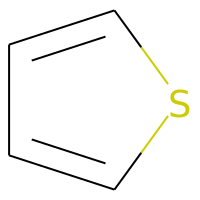

In [6]:
PandasTools.AddMoleculeColumnToFrame(data,'smiles','Molecule')
data = data[0:number_of_data]
data[["smiles","Molecule"]].head(1)


In [7]:
data['smiles'].iloc[10]

'ClC1=CSC=C1'

,smiles,mu,alpha,homo,lumo,gap,r2,zpve,cv,u0,u298,h298,g298,Molecule
0,C,0.0,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,6.469,-40.47893,-40.476062,-40.475117,-40.498597,

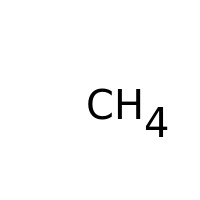

In [8]:
real_data1 = real_data
PandasTools.AddMoleculeColumnToFrame(real_data1,'smiles','Molecule')
real_data1[["smiles","Molecule"]].head(1)
real_data['Molecule'] = real_data1[['Molecule']]
real_data.head(1)

In [9]:
from molvecgen.vectorizers import SmilesVectorizer

smivec = SmilesVectorizer(pad=1, leftpad=True, canonical=False, augment=True)
smivec.fit(real_data.Molecule.values, )

In [10]:
smivec_data = SmilesVectorizer(pad=1, leftpad=True, canonical=False, augment=True)
smivec_data.fit(data.Molecule.values, )

In [2]:
# functions to generate random data

def generate_random_seed_G(size):
    random_data = torch.randn(size)
    return random_data


def generate_random_value(size):
    random_data = np.round(np.random.randint(1, 10000, (1, size))/100,2)
    random_data = torch.FloatTensor(random_data)
    #random_data = torch.round((torch.randn(size) * 10000) / 100)
    #round(random.uniform(min_alpha, max_alpha),2)
    return random_data.view(-1)

generate_random_value(5)

tensor([45.3900, 94.4900, 97.8300, 58.7100, 58.4500])

In [12]:
y = real_data.alpha.values.reshape((-1,1))
X = real_data.Molecule.values

#Normalizing output using standard scaling
scaler = StandardScaler()
X_train = X
y_train = real_data['alpha']
#scaler.fit_transform(y)

print('len(X_train)',len(X_train),'y_train[1]', y_train[1])

len(X_train) 133885 y_train[1] 9.46


In [13]:
data_y = generate_random_value(number_of_data).reshape((-1,1))
data_X = data.Molecule.values
scaler = StandardScaler()
#data_y = scaler.fit_transform(data_y)
data_dataset = SMILESMolDataset(data_X, data_y, smivec_data)
print('data_dataset[10]', data_dataset[10], 'data_y', data_y[10] )


data_dataset[10] (array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
   

In [14]:
train_dataset = SMILESMolDataset(X_train, y_train, smivec)
train_dataset[10]
print('train_dataset[10]', train_dataset[10], 'len(train_dataset[10][0])', len(train_dataset[10][0]) )

train_dataset[10] (array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
  

In [15]:
# return a random SMILES from the GDB13_Subset
def generate_random_seed(size):
    index_list = np.random.randint(1, number_of_data, (1, size))[0]
    random_data = []
    for i in index_list:
          random_data.append( data_dataset[i] )
    #random_data = data_dataset[10]
    return random_data

generate_random_seed(2)[0][1]

tensor([33.8100])

In [16]:
epochs = 5000
dims = smivec.dims
lstm_size = 128  # The size of the LSTM layer
hidden_size = 128  # The size of the hidden non-linear layer
dropout_rate = 0.50 # The dropout rate
out_size = 1        # This is just a single task, so this will be one
batch_size = 128   # The mini_batch size during training
#batch_size = 1   # The mini_batch size during training
G_input_size = 100 # The Generator input data size
learning_rate_D = 0.003  # The Discriminator initial learning rate for the optimizer 
learning_rate_G = 0.001  # The Generator initial learning rate for the optimizer

In [17]:
# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        length = dims[0] 
        number_tokens = dims[1] + 1  # add the label layer
        #print('LSTM input_size', number_tokens)
         
        
        self.lstm = nn.LSTM(input_size=number_tokens, hidden_size=lstm_size, num_layers=1, batch_first=True, bidirectional=False)
        self.fc1 = nn.Linear(lstm_size, hidden_size) # Output layer
        self.activation = nn.ReLU() # Non-Linear ReLU Layer       
        self.fc_out = nn.Linear(hidden_size, out_size) # Output layer
        self.dropout = nn.Dropout(dropout_rate)       
        
        # create loss function
        self.loss_function = nn.MSELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=learning_rate_D)
        #self.lr_scheduler = ReduceLROnPlateau(self.optimiser, mode='min', factor=0.5, patience=50, 
        #          verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-6, eps=1e-08)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, input_tensor, label_tensor):
        # combine seed and label
        
        #print("input_tensor.shape", input_tensor.shape, "label_tensor.shape", label_tensor.shape)
        x = torch.cat((input_tensor, label_tensor), -1)
        #print('after torch.cat', x.shape)
        
        
        out, (h_n, c_n) = self.lstm(x) #LSTM network reads in one-hot-encoded SMILES, h_n is last output, out is for all timesteps
        out = self.dropout(h_n) #Dropout
        out = self.fc1(out) # Pass into the hidden layer
        out = self.activation(out) # Use ReLU on hidden activation
        out = self.dropout(out) # dropout
        out = self.fc_out(out) # Use a linear layer for the output
        return out
    
    
    def train(self, inputs, label_tensor, targets):
        # calculate the output of the network Discriminator
        outputs = self.forward(inputs, label_tensor)
        
        
        #print('outputs', outputs)
        #print('targets', targets)
        # calculate loss
        #outputs = outputs.view(-1)
        #targets = targets.view(-1)
        #print('outputs.shape', outputs.shape, 'targets.shape',targets.shape)
        
        if (outputs.shape != targets.shape):
            print("Generator loss function issue: outputs.shape != targets.shape", outputs.shape, targets.shape)

        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [18]:
from torch.utils.data import DataLoader
data_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True, num_workers=4,drop_last=True )



In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [20]:
%%time
# test discriminator can separate real data from random noise


D = Discriminator()
D.to(device)

for smiles,label in data_loader:
    # real
    target = torch.FloatTensor([1.0]).view(1,1,1).repeat(1, smiles.shape[0] ,1).to(device)
    #print('0.before change label.shape', label.shape, 'smiles', smiles.shape)
    label = label.float().to(device)
    label = label.view(batch_size, 1, 1).repeat(1, smiles.shape[1], 1)
    #print('1.before change label.shape', label.shape, 'smiles', smiles.shape)
    D.train(smiles.to(device).float(), label, target)
    
    # fake
    fake_input = []
    fake_label = []
    for finput, label in generate_random_seed(batch_size):
        fake_input.append(finput)
        fake_label.append(label)
    
    
    fake_input = torch.FloatTensor(fake_input).to(device)
    
    #fake_input = fake_input.reshape(1, fake_input.shape[0], fake_input.shape[1])
    fake_label = torch.FloatTensor(fake_label).to(device)
    #print('2.before change label.shape', fake_input.shape, 'fake_label', fake_label.shape)
    fake_label = fake_label.view(batch_size, 1, 1).repeat(1, fake_input.shape[1], 1)
    #fake_label.unsqueeze(1).repeat(1, fake_input.shape[1], 1)
    #print('fake_input.shape', fake_input.shape, 'fake_label.shape', fake_label.shape)
    target = torch.FloatTensor([0.0]).view(1,1,1).repeat(1, fake_input.shape[0] ,1).to(device)
    D.train(fake_input, fake_label, target)
    
    pass

counter =  1000
counter =  2000
CPU times: user 44.6 s, sys: 1.53 s, total: 46.1 s
Wall time: 46.3 s


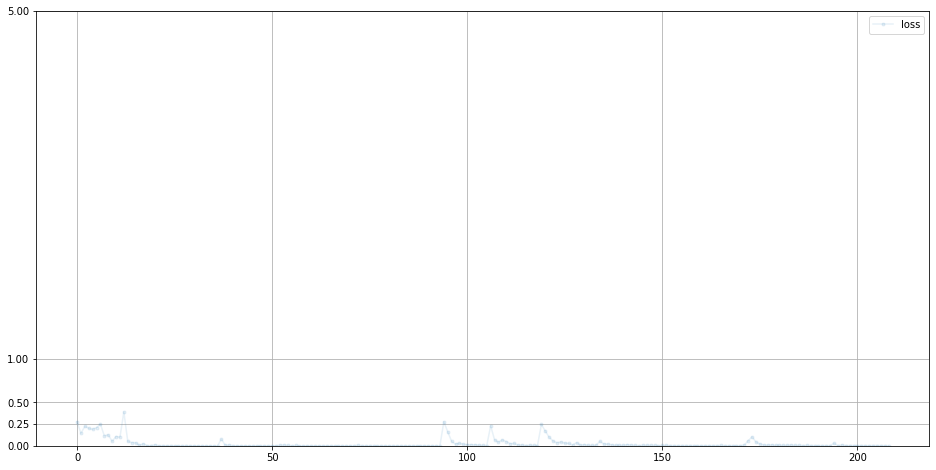

In [21]:
D.plot_progress()

In [22]:

i = 0
for smiles,label in data_loader:
    # real
    target = torch.FloatTensor([1.0]).view(1,1,1).repeat(1, smiles.shape[0] ,1).to(device)
    label = label.float().to(device)
    label = label.view(batch_size, 1, 1).repeat(1, smiles.shape[1], 1)
    print(D.forward(smiles.to(device).float(), label))
    
    i += 1
    if (i >= 4):
        break
    pass

for i in range(4):
    fake_input = []
    fake_label = []
    for finput, label in generate_random_seed(batch_size):
        fake_input.append(finput)
        fake_label.append(label)
    
    
    fake_input = torch.FloatTensor(fake_input).to(device)
    
    #fake_input = fake_input.reshape(1, fake_input.shape[0], fake_input.shape[1])
    fake_label = torch.FloatTensor(fake_label).to(device)
    #print('2.before change label.shape', fake_input.shape, 'fake_label', fake_label.shape)
    fake_label = fake_label.view(batch_size, 1, 1).repeat(1, fake_input.shape[1], 1)
    #print('fake_input.shape', fake_input.shape, 'fake_label.shape', fake_label.shape)
    target = torch.FloatTensor([0.0]).view(1,1,1).repeat(1, fake_input.shape[0] ,1).to(device)
    D.forward(fake_input, fake_label)
    pass


tensor([[[1.0677],
         [0.9250],
         [0.8832],
         [0.9265],
         [0.8934],
         [1.0621],
         [0.9546],
         [0.9389],
         [1.1281],
         [0.9996],
         [0.9905],
         [0.8744],
         [1.0333],
         [1.0207],
         [0.9868],
         [1.0378],
         [1.1594],
         [0.8757],
         [0.8339],
         [0.8352],
         [1.1928],
         [0.8099],
         [1.0017],
         [0.9534],
         [1.1554],
         [1.0951],
         [0.8963],
         [0.9183],
         [1.0261],
         [1.0291],
         [1.2306],
         [1.1043],
         [0.8963],
         [0.9348],
         [0.8983],
         [1.1189],
         [0.7963],
         [1.1232],
         [1.0500],
         [0.8499],
         [0.9480],
         [0.8562],
         [0.8267],
         [0.8341],
         [1.1577],
         [0.8861],
         [1.1281],
         [1.0128],
         [1.0392],
         [0.9887],
         [0.9959],
         [0.7179],
         [1.

In [26]:
# generator class

class Generator(nn.Module):
    
    def __init__(self, batch_size):
        # initialise parent pytorch class
        super().__init__()
        
        self.batch_size = batch_size 
        self.model = nn.Sequential(
            nn.Linear(G_input_size * 2, 200),
            nn.LeakyReLU(0.02),
            #nn.LayerNorm(200),
            nn.Linear(200, number_of_data)
            #nn.Sigmoid()
        )
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=learning_rate_G)
        
        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, seed_tensor, label_tensor):        
        # combine seed and label
        #print('seed_tensor.shape', seed_tensor.shape, 'label_tensor', label_tensor.shape)
        inputs = torch.cat((seed_tensor, label_tensor))
        #print('after torch.cat', inputs.shape)
        outputs = self.model(inputs)
        #print('outputs', outputs)
        return torch.argmax(F.softmax(outputs, dim=0))


    def train(self, D, inputs, label_tensor, targets):
        # calculate the output of the network
        g_output = self.forward(inputs, label_tensor)

        g_data = data_dataset[g_output]
        
        g_input = torch.FloatTensor(g_data[0]).to(device)
        g_input = g_input.reshape(1, g_input.shape[0], g_input.shape[1])
        g_label = torch.FloatTensor(g_data[1]).to(device)
        g_label = g_label.unsqueeze(1).repeat(1, g_input.shape[1], 1)
        if (self.counter % 1000 == 0):
            print('g_output', g_output, 'g_data[1]', g_data[1])        
        
        # pass onto Discriminator
        d_output = D.forward(g_input, g_label)
        
        #print('d_output.shape', d_output.shape, 'targets.shape', targets.shape)
        if (d_output.shape != targets.shape):
            print("Generator loss function issue: d_output.shape != targets.shape", d_output.shape, targets.shape)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    

    def get_smiles(self, label):
        #fake_input = torch.FloatTensor(generate_random_seed_G(batch_size)).to(device)
        #fake_label = torch.FloatTensor([label]).to(device)
        
        fake_input = torch.FloatTensor(generate_random_seed_G(G_input_size)).to(device)
        fake_label = torch.FloatTensor(generate_random_value(G_input_size)).to(device)
        idx = self.forward(fake_input, fake_label).detach().cpu().numpy()
        #print('idx', idx, 'fake_input', fake_input.shape, 'fake_label.shape', fake_label.shape,  'result.shape', result.shape)
        
        #idx = self.get_index(G.forward(fake_input, fake_label)).detach().cpu().numpy()
        return data['smiles'].iloc[idx]
        pass

    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [27]:
# check the generator output is of the right type and shape

G = Generator(1)
G.to(device)

#fake = generate_random_seed()
fake_input = torch.FloatTensor(generate_random_seed_G(G_input_size)).to(device)
fake_label = torch.FloatTensor(generate_random_value(G_input_size)).to(device)
idx = G.forward(fake_input, fake_label)
print('idx', idx)
data_dataset[idx]




idx tensor(56333, device='cuda:0')


(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0],

In [31]:
G.get_smiles(-12.2323)

'[NH2+]=C1OCCCN1C1CCOC1'

In [32]:
%%time 

D = Discriminator()
D.to(device)
G = Generator(batch_size)
G.to(device)

# train Discriminator and Generator

for epoch in range(epochs):
    print ("epoch = ", epoch + 1)

    # train Discriminator and Generator
    for smiles,label in data_loader:
        #########################################################                   
        # train discriminator on true
        #########################################################                   
        target = torch.FloatTensor([1.0]).view(1,1,1).repeat(1, smiles.shape[0] ,1).to(device)
        #print('1.before change label.shape', label.shape, 'smiles', smiles.shape)
        label = label.float().to(device)
        label = label.view(batch_size, 1, 1).repeat(1, smiles.shape[1], 1)
        D.train(smiles.to(device).float(), label, target)
        
        
        #########################################################                   
        # train discriminator on false
        # use detach() so gradients in G are not calculated
        #########################################################                   
        fake_input = torch.FloatTensor(generate_random_seed_G(G_input_size)).to(device)
        fake_label = torch.FloatTensor(generate_random_value(G_input_size)).to(device)
        data_inx = G.forward(fake_input, fake_label).detach()
        #print("data_inx", data_inx)

        fake = data_dataset[data_inx]
        #print('fake', fake)
        
        fake_input = torch.FloatTensor(fake[0]).to(device)
        fake_input = fake_input.reshape(1, fake_input.shape[0], fake_input.shape[1])
        fake_label = torch.FloatTensor(fake[1]).to(device)
        #print('fake_label.shape', fake_label.shape)
        
        fake_label = fake_label.view(fake_label.shape[0], 1, 1).repeat(1, fake_input.shape[1], 1)
        target = torch.FloatTensor([0.0]).view(1,1,1).repeat(1, fake_input.shape[0] ,1).to(device)
        D.train(fake_input, fake_label, target )

        
        #########################################################                   
        # train generator
        #########################################################                   
        fake_input = torch.FloatTensor(generate_random_seed_G(G_input_size)).to(device)
        fake_label = torch.FloatTensor(generate_random_value(G_input_size)).to(device)
        #fake_label = fake_label.unsqueeze(1).repeat(1, fake_input.shape[1], 1)
        target = torch.FloatTensor([0.0]).view(1,1,1).to(device)
        G.train(D, fake_input, fake_label, target)
        
    pass
    
pass


epoch =  1
g_output tensor(80989, device='cuda:0') g_data[1] tensor([7.6800])
counter =  1000
counter =  2000
g_output tensor(30571, device='cuda:0') g_data[1] tensor([2.5200])
epoch =  2
counter =  3000
counter =  4000
g_output tensor(67368, device='cuda:0') g_data[1] tensor([88.6800])
epoch =  3
counter =  5000
counter =  6000
g_output tensor(28501, device='cuda:0') g_data[1] tensor([40.0100])
epoch =  4
counter =  7000
counter =  8000
g_output tensor(28501, device='cuda:0') g_data[1] tensor([40.0100])
epoch =  5
counter =  9000
counter =  10000
g_output tensor(113279, device='cuda:0') g_data[1] tensor([97.3600])
epoch =  6
counter =  11000
counter =  12000
g_output tensor(125145, device='cuda:0') g_data[1] tensor([81.3000])
epoch =  7
counter =  13000
counter =  14000
g_output tensor(124770, device='cuda:0') g_data[1] tensor([52.3800])
epoch =  8
counter =  15000
counter =  16000
g_output tensor(111399, device='cuda:0') g_data[1] tensor([89.4400])
epoch =  9
counter =  17000
counter

epoch =  70
counter =  145000
counter =  146000
g_output tensor(94299, device='cuda:0') g_data[1] tensor([71.3800])
epoch =  71
counter =  147000
counter =  148000
g_output tensor(35378, device='cuda:0') g_data[1] tensor([56.7400])
epoch =  72
counter =  149000
counter =  150000
g_output tensor(125145, device='cuda:0') g_data[1] tensor([81.3000])
epoch =  73
counter =  151000
counter =  152000
g_output tensor(15308, device='cuda:0') g_data[1] tensor([23.5500])
epoch =  74
counter =  153000
counter =  154000
g_output tensor(113279, device='cuda:0') g_data[1] tensor([97.3600])
epoch =  75
counter =  155000
counter =  156000
g_output tensor(125145, device='cuda:0') g_data[1] tensor([81.3000])
epoch =  76
counter =  157000
counter =  158000
g_output tensor(63813, device='cuda:0') g_data[1] tensor([42.1500])
epoch =  77
counter =  159000
counter =  160000
g_output tensor(6240, device='cuda:0') g_data[1] tensor([58.1600])
epoch =  78
counter =  161000
counter =  162000
g_output tensor(95726,

epoch =  138
counter =  287000
counter =  288000
g_output tensor(38349, device='cuda:0') g_data[1] tensor([77.7500])
epoch =  139
counter =  289000
counter =  290000
g_output tensor(5296, device='cuda:0') g_data[1] tensor([28.8800])
epoch =  140
counter =  291000
counter =  292000
g_output tensor(78019, device='cuda:0') g_data[1] tensor([86.1400])
epoch =  141
counter =  293000
counter =  294000
g_output tensor(125145, device='cuda:0') g_data[1] tensor([81.3000])
epoch =  142
counter =  295000
counter =  296000
g_output tensor(95726, device='cuda:0') g_data[1] tensor([68.6500])
epoch =  143
counter =  297000
counter =  298000
g_output tensor(35790, device='cuda:0') g_data[1] tensor([53.4800])
epoch =  144
counter =  299000
counter =  300000
g_output tensor(76944, device='cuda:0') g_data[1] tensor([46.5000])
epoch =  145
counter =  301000
counter =  302000
g_output tensor(6276, device='cuda:0') g_data[1] tensor([37.1800])
counter =  303000
epoch =  146
counter =  304000
g_output tensor(

epoch =  206
counter =  429000
counter =  430000
g_output tensor(6276, device='cuda:0') g_data[1] tensor([37.1800])
epoch =  207
counter =  431000
counter =  432000
g_output tensor(111399, device='cuda:0') g_data[1] tensor([89.4400])
epoch =  208
counter =  433000
counter =  434000
g_output tensor(102348, device='cuda:0') g_data[1] tensor([80.3600])
epoch =  209
counter =  435000
counter =  436000
g_output tensor(94299, device='cuda:0') g_data[1] tensor([71.3800])
epoch =  210
counter =  437000
counter =  438000
g_output tensor(122079, device='cuda:0') g_data[1] tensor([39.3900])
epoch =  211
counter =  439000
counter =  440000
g_output tensor(125145, device='cuda:0') g_data[1] tensor([81.3000])
epoch =  212
counter =  441000
counter =  442000
g_output tensor(95726, device='cuda:0') g_data[1] tensor([68.6500])
counter =  443000
epoch =  213
counter =  444000
g_output tensor(6276, device='cuda:0') g_data[1] tensor([37.1800])
counter =  445000
epoch =  214
counter =  446000
g_output tens

counter =  570000
g_output tensor(100092, device='cuda:0') g_data[1] tensor([16.5600])
epoch =  274
counter =  571000
counter =  572000
g_output tensor(76944, device='cuda:0') g_data[1] tensor([46.5000])
epoch =  275
counter =  573000
counter =  574000
g_output tensor(86393, device='cuda:0') g_data[1] tensor([21.6500])
epoch =  276
counter =  575000
counter =  576000
g_output tensor(98847, device='cuda:0') g_data[1] tensor([79.4500])
epoch =  277
counter =  577000
counter =  578000
g_output tensor(63813, device='cuda:0') g_data[1] tensor([42.1500])
epoch =  278
counter =  579000
counter =  580000
g_output tensor(111399, device='cuda:0') g_data[1] tensor([89.4400])
counter =  581000
epoch =  279
counter =  582000
g_output tensor(35162, device='cuda:0') g_data[1] tensor([94.3900])
counter =  583000
epoch =  280
counter =  584000
g_output tensor(125145, device='cuda:0') g_data[1] tensor([81.3000])
counter =  585000
epoch =  281
counter =  586000
g_output tensor(18138, device='cuda:0') g_d

epoch =  341
counter =  711000
counter =  712000
g_output tensor(111399, device='cuda:0') g_data[1] tensor([89.4400])
epoch =  342
counter =  713000
counter =  714000
g_output tensor(94424, device='cuda:0') g_data[1] tensor([95.2600])
epoch =  343
counter =  715000
counter =  716000
g_output tensor(25617, device='cuda:0') g_data[1] tensor([23.6000])
epoch =  344
counter =  717000
counter =  718000
g_output tensor(1128, device='cuda:0') g_data[1] tensor([64.3700])
epoch =  345
counter =  719000
counter =  720000
g_output tensor(113279, device='cuda:0') g_data[1] tensor([97.3600])
counter =  721000
epoch =  346
counter =  722000
g_output tensor(125145, device='cuda:0') g_data[1] tensor([81.3000])
counter =  723000
epoch =  347
counter =  724000
g_output tensor(111399, device='cuda:0') g_data[1] tensor([89.4400])
counter =  725000
epoch =  348
counter =  726000
g_output tensor(113279, device='cuda:0') g_data[1] tensor([97.3600])
counter =  727000
epoch =  349
counter =  728000
g_output te

counter =  852000
g_output tensor(35378, device='cuda:0') g_data[1] tensor([56.7400])
epoch =  409
counter =  853000
counter =  854000
g_output tensor(35378, device='cuda:0') g_data[1] tensor([56.7400])
epoch =  410
counter =  855000
counter =  856000
g_output tensor(4840, device='cuda:0') g_data[1] tensor([8.1300])
epoch =  411
counter =  857000
counter =  858000
g_output tensor(25617, device='cuda:0') g_data[1] tensor([23.6000])
epoch =  412
counter =  859000
counter =  860000
g_output tensor(35162, device='cuda:0') g_data[1] tensor([94.3900])
counter =  861000
epoch =  413
counter =  862000
g_output tensor(125145, device='cuda:0') g_data[1] tensor([81.3000])
counter =  863000
epoch =  414
counter =  864000
g_output tensor(104504, device='cuda:0') g_data[1] tensor([25.0400])
counter =  865000
epoch =  415
counter =  866000
g_output tensor(12876, device='cuda:0') g_data[1] tensor([29.5200])
counter =  867000
epoch =  416
counter =  868000
g_output tensor(125145, device='cuda:0') g_dat

epoch =  476
counter =  993000
counter =  994000
g_output tensor(113279, device='cuda:0') g_data[1] tensor([97.3600])
epoch =  477
counter =  995000
counter =  996000
g_output tensor(67712, device='cuda:0') g_data[1] tensor([75.0500])
epoch =  478
counter =  997000
counter =  998000
g_output tensor(113279, device='cuda:0') g_data[1] tensor([97.3600])
counter =  999000
epoch =  479
counter =  1000000
g_output tensor(126704, device='cuda:0') g_data[1] tensor([84.5600])
counter =  1001000
epoch =  480
counter =  1002000
g_output tensor(108733, device='cuda:0') g_data[1] tensor([36.8400])
counter =  1003000
epoch =  481
counter =  1004000
g_output tensor(111399, device='cuda:0') g_data[1] tensor([89.4400])
counter =  1005000
epoch =  482
counter =  1006000
g_output tensor(29364, device='cuda:0') g_data[1] tensor([27.4200])
counter =  1007000
epoch =  483
counter =  1008000
g_output tensor(67712, device='cuda:0') g_data[1] tensor([75.0500])
counter =  1009000
epoch =  484
counter =  1010000

KeyboardInterrupt: 

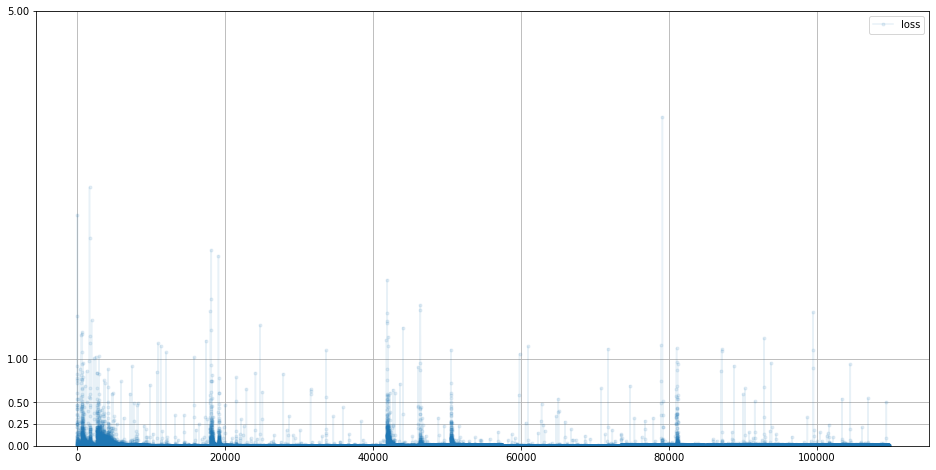

In [33]:
D.plot_progress()

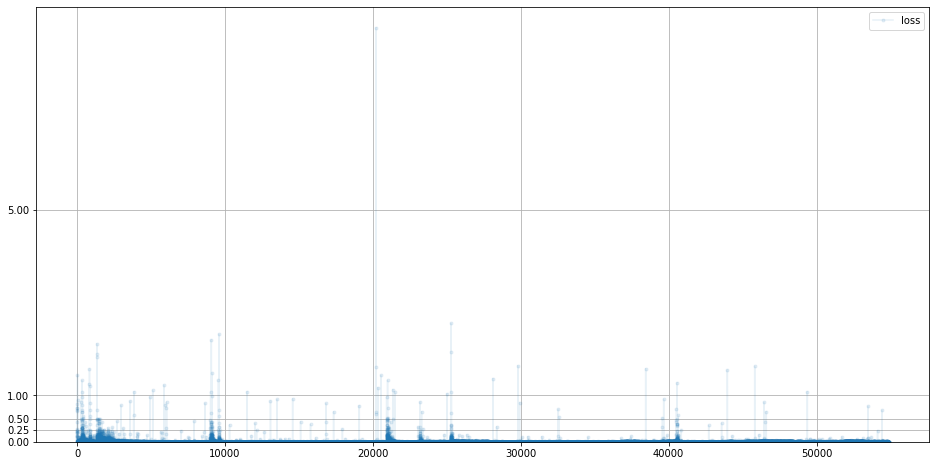

In [34]:
G.plot_progress()

In [35]:
i = 0
for smiles,label in data_loader:
    # real
    target = torch.FloatTensor([1.0]).view(1,1,1).repeat(1, smiles.shape[0] ,1).to(device)
    label = label.float().to(device)
    label = label.view(batch_size, 1, 1).repeat(1, smiles.shape[1], 1)
    print(D.forward(smiles.to(device).float(), label))
    
    i += 1
    if (i >= 4):
        break
    pass

for i in range(4):
    fake_input = []
    fake_label = []
    for finput, label in generate_random_seed(batch_size):
        fake_input.append(finput)
        fake_label.append(label)
    
    
    fake_input = torch.FloatTensor(fake_input).to(device)
    
    #fake_input = fake_input.reshape(1, fake_input.shape[0], fake_input.shape[1])
    fake_label = torch.FloatTensor(fake_label).to(device)
    #print('2.before change label.shape', fake_input.shape, 'fake_label', fake_label.shape)
    fake_label = fake_label.view(batch_size, 1, 1).repeat(1, fake_input.shape[1], 1)
    #print('fake_input.shape', fake_input.shape, 'fake_label.shape', fake_label.shape)
    target = torch.FloatTensor([0.0]).view(1,1,1).repeat(1, fake_input.shape[0] ,1).to(device)
    D.forward(fake_input, fake_label)
    pass


tensor([[[0.8113],
         [1.2931],
         [0.7665],
         [0.9427],
         [0.7659],
         [1.0640],
         [1.1390],
         [0.9654],
         [0.9856],
         [0.5853],
         [0.8784],
         [0.6210],
         [1.2078],
         [1.2330],
         [0.9847],
         [1.5249],
         [1.2691],
         [0.9838],
         [1.0858],
         [0.5948],
         [0.7392],
         [1.0027],
         [0.9658],
         [1.1212],
         [0.7501],
         [0.6321],
         [0.6665],
         [0.9684],
         [0.4393],
         [1.1372],
         [0.7425],
         [0.4491],
         [0.9266],
         [0.8697],
         [1.0292],
         [1.0794],
         [1.0491],
         [0.8813],
         [0.7579],
         [0.8931],
         [0.7607],
         [0.7145],
         [0.7232],
         [1.0339],
         [1.1112],
         [1.0640],
         [1.2773],
         [0.8187],
         [1.1676],
         [1.0221],
         [1.1741],
         [1.0740],
         [1.

In [29]:
fake_input = torch.FloatTensor(generate_random_seed_G(G_input_size)).to(device)
fake_label = torch.FloatTensor(generate_random_value(G_input_size)).to(device)
result = G.forward(fake_input, fake_label).detach()
idx = result.cpu().numpy()
print('result', result, 'idx', idx, 'fake_input', fake_input.shape, 'fake_label.shape', fake_label.shape,  'result.shape', result.shape)
        
#idx = self.get_index(G.forward(fake_input, fake_label)).detach().cpu().numpy()
print(data['smiles'].iloc[idx])

result tensor(39342, device='cuda:0') idx 39342 fake_input torch.Size([100]) fake_label.shape torch.Size([100]) result.shape torch.Size([])
C1CCC2=C(CC[NH2+]C1)OC=N2


In [40]:
for i in range(100):
    print(G.get_smiles(41.9600))
#CC1CC1,41.96

O=C1CC2CCC1COC2
C1COCOC2=CC=CC=C2C1
C1OC2CCCC11COCOC21
C1CC2CCCC1C21CCCOC1
O=C1NCC(CO1)C1=NSC=C1
C1COCOC2=CC=CC=C2C1
C1OC2CCCC11COCOC21
OC1COCC2=C1OC=C2
C1COC2=CC3=C(C=CO3)C=C2C1
OC1COCC2=C1OC=C2
C1CCN(C1)C1=COC2=C1NC=C2
O=C1NCC(CO1)C1=NSC=C1
C1CCN(C1)C1=COC2=C1NC=C2
OC1CCCCN2C=[NH+]CCC12
C1CC2CCOC2(C1)C1=CC=CN1
C1COCOC2=CC=CC=C2C1
O=C1CCC(N1)C1=CC=CN=C1
O=C1C2CC3CCOC1C3C2
C1CC2(C[NH2+]C1C2)C1=CSN=C1
OC1(CCCC1)C1CCCCCO1
C1OC2CCCC11COCOC21
[NH3+]C1CN=C(C1)N1CCOCC1
C1CCN(C1)C1=COC2=C1NC=C2
C1CCN(C1)C1=COC2=C1NC=C2
OC1CC2CCOC1CC[NH2+]2
C1CCN(C1)C1=COC2=C1NC=C2
C1CC2(C[NH2+]C1C2)C1=CSN=C1
O=C1CC2C[NH+]3CC(C1)C2C3
OC1CCC2CC(O)CCCC12
O=C1CCC(CC1)C1=CSN=C1
O=C1NCC(CO1)C1=NSC=C1
C1OCC2(CCC3=C2C=NO3)O1
O=C1CC2CCC3CCCC1C23
O=C1NCC(CO1)C1=NSC=C1
C1OC2CCCC11COCOC21
C1OCC2(CCC3=C2C=NO3)O1
OC1C[NH+]2CCC1COCC2
C1COCOC2=CC=CC=C2C1
C1CCN(C1)C1=COC2=C1NC=C2
C1OC2CCCC11COCOC21
ClC1=CN(C=C1)C1CNC(=S)NC1
OC1=CC=CC2=CN(C=C1)N=C2
O=C1NCC(CO1)C1=NSC=C1
C1COCOC2=CC=CC=C2C1
C1OC2CCCC11COCOC21
OC1COCC2=C1OC=C2
C

In [41]:
for i in range(100):
    print(G.get_smiles(0.3261332))


C1COCOC2=CC=CC=C2C1
O=C1CC2C[NH+]3CC(C1)C2C3
C1CC2[NH2+]C1C1=C2C=CN1
ClC1=CC(=N)N=C2CCOC2=C1
OC1CCC(C1)[NH2+]C1CCOC1
C1OCC2(CCC3=C2C=NO3)O1
C1CC2CCCC1C21CCCOC1
C1COCOC2=CC=CC=C2C1
ClC1=CN2CC(=O)NC2=C1Cl
C1OC2CCCC11COCOC21
O=C1NCC(CO1)C1=NSC=C1
OC1CC2CCOC1CC[NH2+]2
C1CC2CCCC1C21CCCOC1
OC1C[NH+]2CCC(CC2)C1=O
O=C1CCC(N1)C1=CC=CN=C1
C1OC2CCCC11COCOC21
C1CCN(C1)C1=COC2=C1NC=C2
OC1C2CCC1CCOCC2
C1CC2CC[NH+]3CCC2(C1)C3
C1CCN(C1)C1=COC2=C1NC=C2
OC1COCC2=C1OC=C2
O[C-]1C=CC2=C1SN=N2
OC1COCC2=C1OC=C2
OC1CCCCN2C=[NH+]CCC12
O=C1NCC(CO1)C1=NSC=C1
[NH2+]=C1CC2=C(CN1)SC=N2
C1OC2CCCC11COCOC21
C1COCOC2=CC=CC=C2C1
C1CCCC2=NC(NCC1)=CO2
C1CCN(C1)C1=COC2=C1NC=C2
C1CC2=NON=C2CC[NH2+]1
C1CC2[NH2+]C1C1=C2C=CN1
C1CCN(C1)C1=COC2=C1NC=C2
C1OCC2(CCC3=C2C=NO3)O1
C1OCC2(CCC3=C2C=NO3)O1
[NH2+]=C1CCC2=C(C=CS2)N=CN1
C1CC2(C[NH2+]C1C2)C1=CSN=C1
O=C1CCC(N1)C1=CC=CN=C1
C1CC2CCC3COCC23C1
O[C-]1C=CC2=C1SN=N2
O=C1CCC(N1)C1=CC=CN=C1
C1OCC2(CCC3=C2C=NO3)O1
C1CCN(C1)C1=COC2=C1NC=C2
O=C1NCC(CO1)C1=NSC=C1
OC1CCCCC1C1=CC=NN=C1
C1OC

In [42]:
for i in range(100):
    print(G.get_smiles(73.27))

OC1COCC2=C1OC=C2
OC1=CC(Cl)=C2COCC2=N1
C1CCN(C1)C1=COC2=C1NC=C2
OC1CC2CCOC1CC[NH2+]2
C1OC2CCCC11COCOC21
C1CCCC2=NC(NCC1)=CO2
O=C1CC2CCC3CCCC1C23
C1CC2[NH2+]C1C1=C2C=CN1
C1CCC(CC[NH2+]C1)C1=CC=CO1
ClC1=CN(C=C1Cl)C1=[NH+]CCNC1
ClC1=CN(C=C1Cl)C1=[NH+]CCNC1
C1COC2=CC3=C(C=CO3)C=C2C1
C1OC2CCCC11COCOC21
OC1CCC2=NC=CN2C1
O=C1CC2CCC3CCCC1C23
C1OCC2(CCC3=C2C=NO3)O1
C1OC2CCCC11COCOC21
O=C1CCC(N1)C1=CC=CN=C1
ClC1=CN(C=C1Cl)C1=[NH+]CCNC1
C1CCN(C1)C1=COC2=C1NC=C2
[O-]C1=CSC2=C1C(Cl)=CN=C2
C1CC2=CN(C=C2C1)C1=NNC=C1
C1COCOC2=CC=CC=C2C1
C1COC2=NOC=C2C1
OC1C2CCC1CCOCC2
C1CCCC2=NC(NCC1)=CO2
[NH2+]=C1NCCCCC2CCC1C2
C1OC2CCCC11COCOC21
C1CC2=C(C[NH2+]1)SC1=C2C=NO1
O=C1CC2CCOC(CC2)C1
O=C1NCC(CO1)C1=NSC=C1
O=C1CCC(N1)C1=CC=CN=C1
ClC1=CN(C=C1Cl)C1=[NH+]CCNC1
C1CC2(C[NH2+]C1C2)C1=CSN=C1
[O-]C1=C2C(CC3=C2C=CO3)=CS1
O=C1NCCCC(N1)C1=CC=CN1
C1CCN(C1)C1=COC2=C1NC=C2
C1CCN(C1)C1=COC2=C1NC=C2
C1OC2CCCC11COCOC21
C1OC2CCCC11COCOC21
C1CCN(C1)C1=COC2=C1NC=C2
C1CC2OC3=C(C=NO3)C2O1
C1CCN(C1)C1=COC2=C1NC=C2
ClC1=CN(C=C1Cl)C1

In [43]:
import pickle
from datetime import datetime

now = datetime.now() 
date_time = now.strftime("%Y%m%d%H%M")
G_filename = 'pre_train_model/GAN13G' + date_time + '.sav'
print('save model to file:', G_filename)
pickle.dump(G, open(G_filename, 'wb'))

D_filename = 'pre_train_model/GAN13D' + date_time + '.sav'
print('save model to file:', G_filename)
pickle.dump(D, open(D_filename, 'wb'))


#G_model = pickle.load(open(G_filename, 'rb'))

save model to file: pre_train_model/GAN13G202104121727.sav
save model to file: pre_train_model/GAN13G202104121727.sav
